In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import networkx as nx
from scipy.special import softmax
from tqdm import tqdm
from random import shuffle
import copy
from collections import defaultdict
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from uga import UGA

In [2]:
data = pd.read_csv('nyc_citi.csv')
data = data.loc[[type(i)==str for i in data['start station name']]]
data = data.loc[[type(i)==str for i in data['end station name']]]
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [3]:
data.starttime=data.starttime.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data.stoptime=data.stoptime.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
print(data.shape)

(559644, 15)


In [4]:
def build_station_graph(data,starttime,stoptime):
    graphx=nx.Graph()
    filtered_data = data[(data['starttime']>=starttime) & (data['stoptime']<=stoptime)]
    locations = list(set(filtered_data['start station name']).union(filtered_data['end station name']))
    vertices = pd.Series([{}]*len(locations),index=locations)
    for loc in locations:
        vertices[loc] = {'change':0,'x':np.random.random(),'y':np.random.random(),'type':''}
        
    for i in filtered_data['start station name']:
        vertices[i]['change'] -= 1
    for i in filtered_data['end station name']:
        vertices[i]['change'] += 1
    for loc in locations:
        if vertices[loc]['change'] > 0:
            vertices[loc]['type'] = 'overflow'
        if vertices[loc]['change'] < 0:
            vertices[loc]['type'] = 'underflow'
    vertices = vertices.loc[[x['type'] != '' for x in vertices]]
    for vertex in vertices.index:
        graphx.add_node(vertex,bipartite=int(vertices[vertex]['type']=='overflow'))
    #print(vertices)
    nx.set_node_attributes(graphx, {i: vertices[i] for i in vertices.index}) 
    for i in range(len(vertices.index)-1):
        for j in range(len(vertices.index[i:])):
            if vertices[vertices.index[i]]['type'] != vertices[vertices.index[j]]['type']:
                x1=vertices[vertices.index[i]]['x']
                y1=vertices[vertices.index[i]]['y']
                x2=vertices[vertices.index[j]]['x']
                y2=vertices[vertices.index[j]]['y']
                graphx.add_weighted_edges_from([(vertices.index[i],vertices.index[j],euc_dis(x1,y1,x2,y2))])
    return graphx

def cloned_station_vertices(graphx):
    nodes = list(graphx.nodes())
    for node in nodes:
        if graphx.nodes[node]['change']>1:
            for i in range(graphx.nodes[node]['change']-1):
                i = i+1
                graphx.add_nodes_from([(str(node)+str(i),graphx.nodes[node])],bipartite=int(graphx.nodes[node]['bipartite']))
                new_node_name = str(node)+str(i)
                new_node_data = graphx.nodes[new_node_name]
                for node_ in graphx.nodes:
                    if np.sign(new_node_data['change']) != np.sign(graphx.nodes[node_]['change']):
                        x1=new_node_data['x']
                        y1=new_node_data['y']
                        x2=graphx.nodes[node_]['x']
                        y2=graphx.nodes[node_]['y']
                        graphx.add_weighted_edges_from([(node_,new_node_name,euc_dis(x1,y1,x2,y2))])
    return graphx
                


                    
            

In [5]:
def euc_dis(x1,y1,x2,y2):
        return ((x1-x2)**2+(y1-y2)**2)**.5
graph = build_station_graph(data,data.loc[0,'starttime'],data.loc[10,'stoptime'])
#print(graph['E 6 St & Avenue D'])
overflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='overflow'}
underflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='underflow'}


cgraph = cloned_station_vertices(graph)
workers = {i:{
                'type':'worker',
               'xs':np.random.random(),
               'ys':np.random.random(),
               'xe':np.random.random(),
               'ye':np.random.random()
              } for i in range(np.min([len(underflow), len(overflow)]))}
cwgraph = copy.deepcopy(cgraph)
print(cwgraph.nodes)
cwgraph.add_nodes_from(range(len(workers)))
nx.set_node_attributes(cwgraph, workers) 
cwgraph.add_edges_from([(w,s) for w in workers for s in cgraph.nodes ])
print(cwgraph.nodes)
print(cwgraph.nodes[1])

['E 10 St & Avenue A', 'Pershing Square South', 'Allen St & Rivington St', 'E 7 St & Avenue A', '10 Ave & W 28 St', 'W 22 St & 10 Ave', 'Washington Park', 'Allen St & Stanton St', 'St Marks Pl & 2 Ave', 'W 22 St & 8 Ave', 'Forsyth St & Broome St', 'W 26 St & 8 Ave', 'W 54 St & 9 Ave', 'Greenwich St & W Houston St', 'Pershing Square North', 'E 6 St & Avenue B', 'Clermont Ave & Lafayette Ave', 'W 37 St & 10 Ave', 'Ashland Pl & Hanson Pl', 'Cadman Plaza West & Montague St', 'E 4 St & 2 Ave', 'W 13 St & 6 Ave', 'Shevchenko Pl & E 7 St', 'E 20 St & 2 Ave', 'Christopher St & Greenwich St', '8 Ave & W 31 St N', 'Broadway & W 24 St', 'DeKalb Ave & S Portland Ave', 'University Pl & E 14 St', 'Catherine St & Monroe St', 'Atlantic Ave & Fort Greene Pl', 'E 31 St & 3 Ave', 'E 58 St & 3 Ave', 'Pike St & E Broadway', 'Cleveland Pl & Spring St', 'W 13 St & 7 Ave', 'Lafayette St & E 8 St', '9 Ave & W 22 St', 'Fulton St & Grand Ave', 'Broadway & W 29 St', 'Murray St & West St', '9 Ave & W 18 St', 'Suff

In [6]:
uga = UGA(cwgraph)

best, score, log = uga.run(0.1,0.1,100,100)

100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


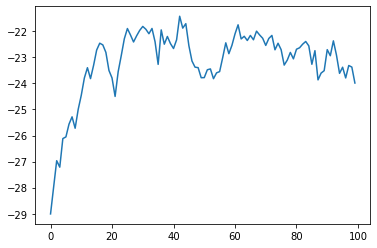

In [7]:
plt.plot(log)
plt.show()

In [8]:

edge_list = defaultdict(lambda:{})
for edge in cgraph.edges:
    if graph.edges[edge]['weight'] > 0 and cgraph.nodes[edge[0]]['type'] != 'worker' and cgraph.nodes[edge[0]]['type'] != 'worker':
        edge_list[edge[0]][edge[1]] = graph.edges[edge]['weight']
        edge_list[edge[1]][edge[0]] = graph.edges[edge]['weight']
#print(edge_list)

worker = {node:{} for node in cwgraph.nodes() if cwgraph.nodes[node]['type']=='worker'}



In [47]:

def euc_tri(worker, underflow, overflow, graph):
    worker_data = graph.nodes[worker]
    underflow_data = graph.nodes[underflow]
    overflow_data = graph.nodes[overflow]
    return euc_dis(worker_data['xe'],worker_data['ye'],underflow_data['x'],underflow_data['y']) + euc_dis(worker_data['xs'],worker_data['ys'],overflow_data['x'],overflow_data['y']) + euc_dis(underflow_data['x'],underflow_data['y'],overflow_data['x'],overflow_data['y'])

def matching_score(matching,graph):
    triplets = []
    finished = {}
    for u1 in matching.keys():
        temp = {}
        if type(u1)==str:
            u2 = matching[u1]
            u1,u3 = u1.split('|')
        else:
            u2 = matching[u1]
            u2,u3 = u2.split('|')
        temp[graph.nodes[u1]['type']] = u1
        temp[graph.nodes[u2]['type']] = u2
        temp[graph.nodes[u3]['type']] = u3
        triplets.append(temp)
    w = 0
    for i in triplets:
        w += euc_tri(i['worker'],i['underflow'],i['overflow'],graph)
    return triplets,w


In [50]:

matching = bipartite.matching.minimum_weight_full_matching(cgraph)
spwgraph =nx.Graph()
for key in matching.keys():
    if cgraph.nodes[key]['type'] =='overflow':
        for w, worker_ in enumerate(worker):
            spwgraph.add_edge((key+'|'+matching[key]),w,
                              weight=cgraph.edges[key, matching[key]]['weight']+
                             euc_dis(cwgraph.nodes[worker_]['xs'],cwgraph.nodes[worker_]['ys'],cgraph.nodes[key]['x'],cgraph.nodes[key]['y']) +
                             euc_dis(cwgraph.nodes[worker_]['xe'],cwgraph.nodes[worker_]['ye'],cgraph.nodes[matching[key]]['x'],cgraph.nodes[matching[key]]['y'])
                                         )
matching2 = bipartite.matching.minimum_weight_full_matching(spwgraph)
#print(matching2)
matching_score(matching2,cwgraph)


{'Cadman Plaza West & Montague St|Forsyth St & Broome St': 21, 'Greenwich St & W Houston St|E 58 St & 3 Ave': 2, 'Catherine St & Monroe St|10 Ave & W 28 St': 6, 'E 7 St & Avenue A|9 Ave & W 22 St': 16, '8 Ave & W 31 St N|E 4 St & 2 Ave': 4, 'W 22 St & 10 Ave|Ashland Pl & Hanson Pl': 15, 'Shevchenko Pl & E 7 St|Allen St & Stanton St': 19, 'E 20 St & 2 Ave|W 54 St & 9 Ave': 1, '9 Ave & W 18 St|Pershing Square South': 18, 'Allen St & Rivington St|Lafayette St & E 8 St': 5, '8 Ave & W 31 St N2|Broadway & W 29 St': 14, 'Pershing Square North|E 31 St & 3 Ave': 17, 'W 37 St & 10 Ave|DeKalb Ave & S Portland Ave': 3, '8 Ave & W 31 St N1|Murray St & West St': 10, 'University Pl & E 14 St|W 26 St & 8 Ave': 8, 'E 6 St & Avenue B|Atlantic Ave & Fort Greene Pl': 12, 'Clermont Ave & Lafayette Ave|Broadway & W 24 St': 11, 'St Marks Pl & 2 Ave|W 13 St & 7 Ave': 9, '9 Ave & W 18 St1|9 Ave & W 14 St': 13, 'W 13 St & 6 Ave|W 22 St & 8 Ave': 0, 'Mercer St & Spring St|E 10 St & Avenue A': 7, 'Washington Par

([{'overflow': 'Cadman Plaza West & Montague St',
   'worker': 21,
   'underflow': 'Forsyth St & Broome St'},
  {'overflow': 'Greenwich St & W Houston St',
   'worker': 2,
   'underflow': 'E 58 St & 3 Ave'},
  {'overflow': 'Catherine St & Monroe St',
   'worker': 6,
   'underflow': '10 Ave & W 28 St'},
  {'overflow': 'E 7 St & Avenue A',
   'worker': 16,
   'underflow': '9 Ave & W 22 St'},
  {'overflow': '8 Ave & W 31 St N',
   'worker': 4,
   'underflow': 'E 4 St & 2 Ave'},
  {'overflow': 'W 22 St & 10 Ave',
   'worker': 15,
   'underflow': 'Ashland Pl & Hanson Pl'},
  {'overflow': 'Shevchenko Pl & E 7 St',
   'worker': 19,
   'underflow': 'Allen St & Stanton St'},
  {'overflow': 'E 20 St & 2 Ave', 'worker': 1, 'underflow': 'W 54 St & 9 Ave'},
  {'overflow': '9 Ave & W 18 St',
   'worker': 18,
   'underflow': 'Pershing Square South'},
  {'overflow': 'Allen St & Rivington St',
   'worker': 5,
   'underflow': 'Lafayette St & E 8 St'},
  {'overflow': '8 Ave & W 31 St N2',
   'worker': 14